## Step 0: Install Dependencies and Import Libraries

In [1]:
! pip install opencv-python
! pip install matplotlib
! pip install scikit-learn

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Step 1: Vizualize the Data

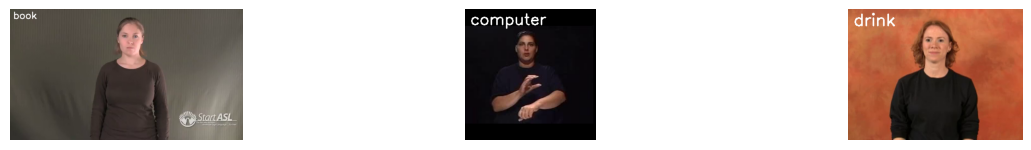

In [3]:
# Create a Matplotlib figure and specify the size of the figure
plt.figure(figsize = (20, 20))

# Dataset directory name - CHANGE FOR CURRENT DATASET
dataset_directory_name = 'Data/grouped_videos_book_drink_computer'

# Get the names of the classses
all_class_names = os.listdir(dataset_directory_name)

# Iterate through all labels
for index in range(len(all_class_names)):
    # Retrieve a class name using the index
    selected_class_name = all_class_names[index]

    # Retrieve the list of all video files present in the class directory
    video_file_names_list = os.listdir(f'{dataset_directory_name}/{selected_class_name}')

    # Skip empty classes
    if len(video_file_names_list) == 0:
        continue

    # Select a video file from the class directory
    selected_video_file_name = video_file_names_list[0]

    # Init a VideoCapture object to read from the video file
    video_reader = cv2.VideoCapture(f'{dataset_directory_name}/{selected_class_name}/{selected_video_file_name}')

    # Read the first frame of the video file
    _, bgr_frame = video_reader.read()

    # Releases the VideoCapture object
    video_reader.release()

    # Convert the frame from BGR to RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame
    plt.subplot(10, 4, index + 1)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Step 2: Preprocess the Dataset

In [4]:
# Specify the height and width to which each video frame will be resized to in our dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence
# Videos are 25fps and 1-2 second each
# Each video is 25-50 frames total
# So we will only feed 15 frames of the original videos to the model 
SEQUENCE_LENGTH = 15

# Specify the directory containing the dataset
# DATASET_DIR = dataset_directory_name

# Specify the list containing the names of the classes used for training
CLASS_LIST = all_class_names

### Step 2.1: Create a Function to Extract, Resize, and Normaize Frames

In [5]:
def frames_extraction(video_path):
    # Declare a list to store the video frames that will be extracted
    frames_list = []

    # Create a VideoCapture object to read the video file
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the number of frames to skip between each extracted frame
    # This ensures that SEQUENCE_LENGTH frames are extracted evenly throughout the video
    skip_frame_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Loop through the desired number of frames (SEQUENCE_LENGTH)
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the position of the next frame to be read, skipping frames evenly
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame_window)

        # Read the frame from the video at the current position
        success, frame = video_reader.read()

        # If reading the frame fails (e.g., video ends early), exit the loop
        if not success:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize the frame to a specific height and width (IMAGE_HEIGHT and IMAGE_WIDTH)
        resized_frame = cv2.resize(gray_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the pixel values by dividing by 255 to scale them between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame to the list of frames
        frames_list.append(normalized_frame)

    # Release the video capture object to free up resources
    video_reader.release()

    # Return the list of extracted and normalized frames
    return frames_list


### Step 2.2: Create a Function for Dataset Creation

In [6]:
def create_dataset(dataset_dir):
    # Initialize empty lists to store the features (frames), labels (class indices), and video file paths
    features = []
    labels = []
    video_file_paths = []

    # Iterate over the list of classes using enumerate, which gives both the index and class name
    for class_index, class_name in enumerate(CLASS_LIST):
        # Print the current class being processed to keep track of progress
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of all files in the current class directory
        files_list = os.listdir(os.path.join(dataset_dir, class_name))

        # Iterate over all the video files in the current class
        for file_name in files_list:
            # Construct the full path to the video file
            video_file_path = os.path.join(dataset_dir, class_name, file_name)

            # Extract frames from the video file using the frames_extraction function
            frames = frames_extraction(video_file_path)

            # Append the extracted frames (features) to the features list
            features.append(frames)
            
            # Append the class index (label) to the labels list to associate the frames with their class
            labels.append(class_index)

            # Append the video file path for reference or debugging
            video_file_paths.append(video_file_path)

    # Convert the features and label lists to a NumPy array 
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the extracted features, labels, and video file paths
    return features, labels, video_file_paths


In [7]:
# Create the dataset
features, labels, video_file_paths = create_dataset("Data/grouped_videos_book_drink_computer")

Extracting Data of Class: book
Extracting Data of Class: computer
Extracting Data of Class: drink


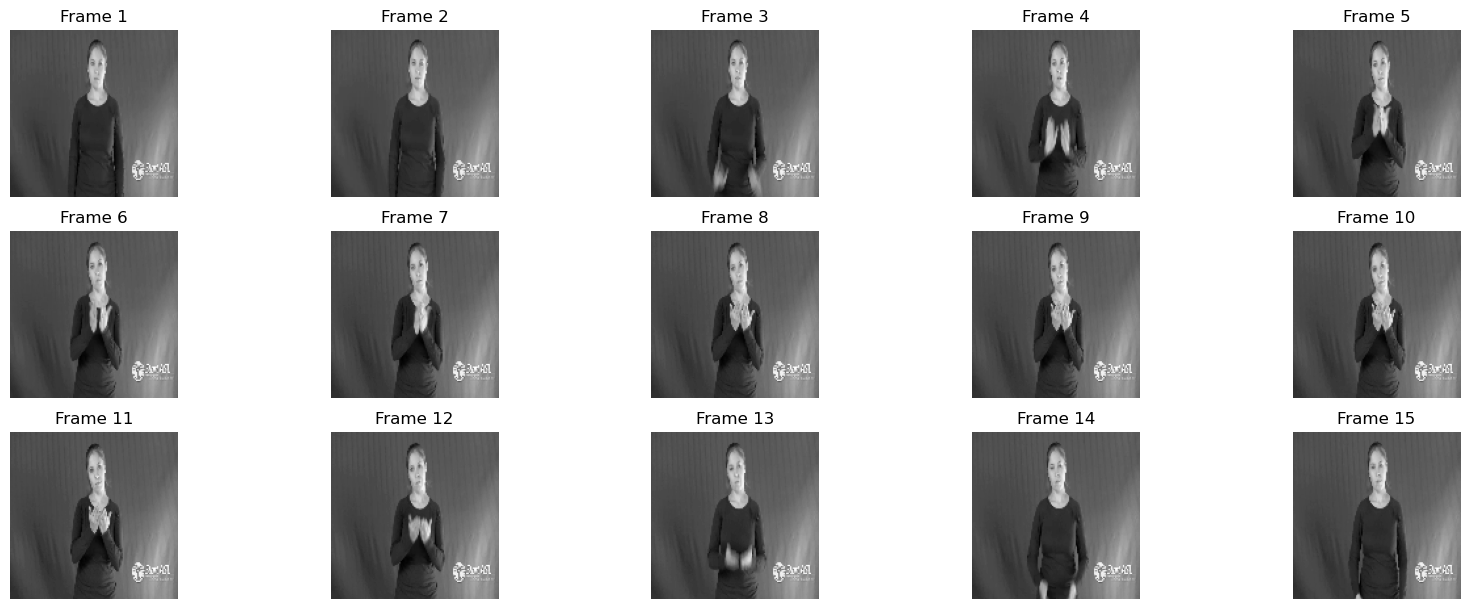

In [8]:
# Visualize a sequence of 15 frames from the first video
plt.figure(figsize=(20, 10))

# Ensure we don't exceed the available frames
sequence_length = min(20, len(features[0]))

for i in range(sequence_length):
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns for 20 frames
    plt.imshow(features[0][i], cmap= 'gray')  # First video, ith frame
    plt.title(f'Frame {i + 1}')
    plt.axis('off')

plt.show()

## Step 3: One-hot-encode and Split Data into Train and Test

In [9]:
# Use Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
# Split the data into Train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.25, shuffle=True,
                                                                            random_state=27)

## Step 4: Implement the ConvLSTM Approach

In [11]:
def create_convlstm_model():
    model = Sequential()

    # Define model architecture
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation="tanh", data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation="tanh", data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation="tanh", data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh", data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same", data_format="channels_last"))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASS_LIST), activation="softmax"))

    # Display model summary
    model.summary()

    return model


In [12]:
# Construct ConvLSTM Model
convlstm_model = create_convlstm_model()
print("Model Created Sucessfully")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 15, 126, 126, 4)   736       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 63, 63, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 15, 63, 63, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 15, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 31, 31, 8)    0         
 3D)                                                             
                                                        

### Step 4.1: Compile and Train the Model

In [15]:
# Create an instance of early stopping callback
# Stop if the val_loss stops improving after 5 epochs
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics values to the model
convlstm_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Start training the model
convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=20, batch_size=4,
                                                     shuffle=True, validation_split=0.2,
                                                     callbacks=[early_stopping_callback])

Epoch 1/20
16/16 [==============================] - 17s 598ms/step - loss: 0.6583 - accuracy: 0.7097 - val_loss: 1.0603 - val_accuracy: 0.5625
Epoch 2/20
16/16 [==============================] - 8s 535ms/step - loss: 0.4785 - accuracy: 0.7903 - val_loss: 0.9954 - val_accuracy: 0.6250
Epoch 3/20
16/16 [==============================] - 9s 534ms/step - loss: 0.4044 - accuracy: 0.8226 - val_loss: 1.3104 - val_accuracy: 0.5000
Epoch 4/20
16/16 [==============================] - 9s 549ms/step - loss: 0.3035 - accuracy: 0.8710 - val_loss: 1.2585 - val_accuracy: 0.5625
Epoch 5/20
16/16 [==============================] - 8s 527ms/step - loss: 0.2237 - accuracy: 0.9194 - val_loss: 1.3432 - val_accuracy: 0.5625
Epoch 6/20
16/16 [==============================] - 9s 558ms/step - loss: 0.2262 - accuracy: 0.9194 - val_loss: 1.2539 - val_accuracy: 0.6250
Epoch 7/20
16/16 [==============================] - 11s 663ms/step - loss: 0.3039 - accuracy: 0.8871 - val_loss: 1.3830 - val_accuracy: 0.5625


### Step 4.2: Evaluate the Trained Model

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 880ms/step - loss: 0.9772 - accuracy: 0.7778


### Step 4.3: Save the Model (Optional)

In [17]:
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# # Get the current date and time in a datetime object
# date_time_format = "%Y_%m_%d__%H_%M_%S"
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# # Save model with useful name
# model_file_name = f"convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5"
# convlstm_model.save(model_file_name)

### Step 4.4: Plot Model's Loss and Accuracy Training Curves

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as X-Axis of the graph
    epochs = range(len(metric_value_1))

    # Plot the graph
    plt.plot(epochs, metric_value_1, "blue", label=metric_name_1)
    plt.plot(epochs, metric_value_2, "red", label=metric_name_2)
    plt.title(str(plot_name))

    # Add legend to the plot
    plt.legend()

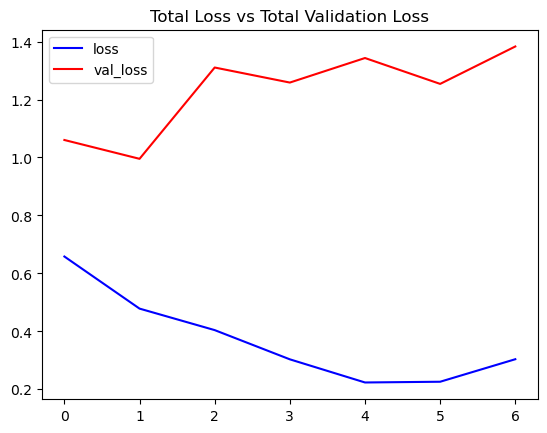

In [19]:
# Visualize the training and validation loss metrics
plot_metric(convlstm_model_training_history, "loss", "val_loss", "Total Loss vs Total Validation Loss")

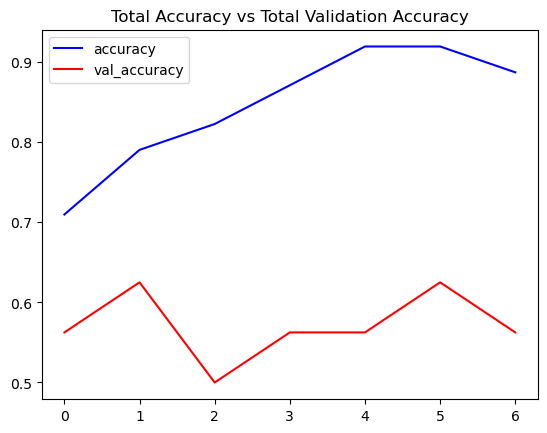

In [20]:
# Visulaize the training and validation accuracy metrics
plot_metric(convlstm_model_training_history, "accuracy", "val_accuracy", "Total Accuracy vs Total Validation Accuracy")

## Step 5: Use the Trained Model to Make Predictions on Test Dataset

In [21]:
# Load in trained model (must change name for different models)
model = load_model("convlstm_model__Date_Time_2024_11_09__15_35_01__Loss_0.9532026648521423__Accuracy_0.7037037014961243.h5")

In [22]:
# Perform predictions on the test data set
predictions = model.predict(features_test)

# Convert one-hot-encoded labels back to class indicies
y_true = labels_test.argmax(axis=1)

# Get the predicted class indicies
y_pred = predictions.argmax(axis=1)

1/1 [==============================] - 1s 814ms/step


### Step 5.1: Compute the Confusion Matrix

In [23]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print a classification report for precision, recall, and F1-score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.80      0.44      0.57         9
           2       0.60      0.90      0.72        10

    accuracy                           0.70        27
   macro avg       0.75      0.70      0.70        27
weighted avg       0.74      0.70      0.69        27



### Step 5.2: Plot the Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

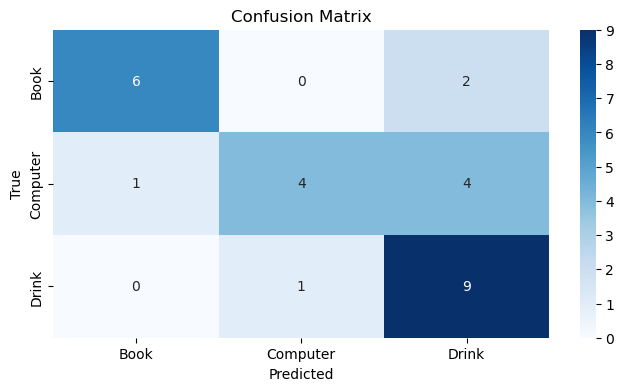

In [24]:
# Define class names (change for different datasets)
class_names = ["Book", "Computer", "Drink"]

# Plot the confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

## Step 6: Test Model on Real Videos

In [25]:
# Create the dataset
features, labels, video_file_paths = create_dataset("Data/tony_test_videos")

Extracting Data of Class: book
Extracting Data of Class: computer
Extracting Data of Class: drink


In [26]:
# Perform predictions on the test data set
predictions = model.predict(features)

# Get the predicted class indicies
y_pred = predictions.argmax(axis=1)

1/1 [==============================] - 0s 143ms/step


In [27]:
# Generate the confusion matrix
cm = confusion_matrix(labels, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

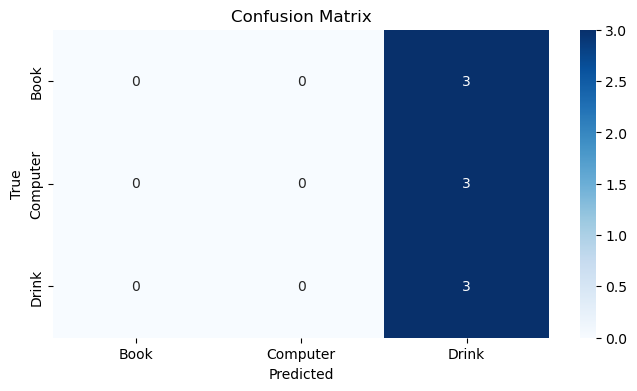

In [28]:
# Define class names (change for different datasets)
class_names = ["Book", "Computer", "Drink"]

# Plot the confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

## Step 7: Test Model on Live Input

### Step 7.1: Create a Function to Preprocess a Single Frame

In [29]:
def preprocess_frame(frame):
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the frame to match the model input size
    resized_frame = cv2.resize(gray_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the frame pixel values to [0, 1]
    normalized_frame = resized_frame / 255.0

    return normalized_frame

### Step 7.2: Create a Function to Predict the Class From a Sequence of Frames

In [30]:
def predict_action(frames):
    if len(frames) == SEQUENCE_LENGTH:
        # Prepare the input for the model
        input_data = np.array(frames).reshape(1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 1)  
        predictions = model.predict(input_data)
        predicted_class = np.argmax(predictions, axis=1)[0]
        return CLASS_LIST[predicted_class]
    return None

### Step 7.3: Use Webcam to Capture Video Data

In [31]:
# Initialize webcam
cap = cv2.VideoCapture(0)  # 0 is the default webcam

# Buffer to store the rolling sequence of frames
frame_buffer = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the current frame
    preprocessed_frame = preprocess_frame(frame)

    # Add the frame to the buffer
    frame_buffer.append(preprocessed_frame)

    # Maintain the buffer size to match SEQUENCE_LENGTH
    if len(frame_buffer) > SEQUENCE_LENGTH:
        frame_buffer.pop(0)

    # Predict the action if the buffer is full
    action = predict_action(frame_buffer)

    # Display the predicted action on the video feed
    display_text = action if action else "Waiting for Input..."
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the video feed
    cv2.imshow("ASL Live Prediction", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 198ms/step
